In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time

from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from sklearn.neighbors import KernelDensity
import statsmodels.api as sma

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from IHDPDataModule import *
from estimators import *
from utils import *
from mmr_utils import *

In [2]:
whi_cont = pd.read_csv('/data/whi/data/main_study/processed/cont_table.csv')
whi_ctos = pd.read_csv('/data/whi/data/main_study/processed/ctos_table.csv')
whi_merged = pd.read_csv('/data/whi/data/main_study/processed/merged.csv')

In [53]:
whi_cont

,Unnamed: 0,AGE,F20DAYS,LSTVISDY,LSTMAMDY,LSTPAPDY,TIMELAST,F2DAYS,F30DAYS,F31DAYS,...,HIP,SYST,DIAS,BMI,WHR,CBCDAYS,HEMATOCR,HEMOGLBN,PLATELET,WBC
0,0,68.0,-56.0,-275.289118,-762.0,-759.057793,7.245407,-66.0,-36.0,-36.0,...,92.000000,105.0,70.0,20.70313,0.760870,-56.0,36.9,12.0,235.0,4.6
1,1,55.0,-101.0,-139.000000,-353.0,-475.000000,1.249180,-147.0,-35.0,-45.0,...,92.000000,113.0,72.0,22.57050,0.798910,-101.0,36.5,12.2,192.0,3.4
2,2,54.0,-74.0,-201.000000,-141.0,-201.000000,4.174880,-229.0,-42.0,-42.0,...,120.000000,118.0,85.0,38.52147,0.879170,-74.0,38.8,13.4,264.0,6.6
3,3,54.0,-64.0,-92.000000,-1372.0,-759.057793,0.920450,-226.0,-34.0,-34.0,...,137.000000,124.0,74.0,36.79474,0.766420,-64.0,39.8,13.8,195.0,5.5
4,4,54.0,-69.0,-117.000000,-785.0,-117.000000,1.577910,-69.0,-69.0,-42.0,...,106.500000,125.0,76.0,28.41658,0.812210,-44.0,41.6,14.2,221.0,10.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50114,50114,54.0,-2.0,-353.000000,-353.0,-353.000000,11.538460,-121.0,-2.0,-2.0,...,93.000000,116.0,76.0,21.66404,0.688170,-2.0,40.0,14.0,165.0,3.1
50115,50115,55.0,-4.0,-275.289118,-2908.0,-759.057793,7.245407,-26.0,-4.0,-4.0,...,87.000000,118.0,83.0,23.60807,0.793100,-4.0,34.1,11.4,253.0,4.9
50116,50116,70.0,-2.0,-354.000000,-566.0,-536.000000,11.571330,-130.0,-2.0,-2.0,...,105.731832,175.0,102.0,22.08815,0.812979,-2.0,41.0,13.9,396.0,4.9
50117,50117,70.0,-12.0,-50.000000,-141.0,-141.000000,1.249180,-24.0,-12.0,-12.0,...,87.000000,134.0,66.0,23.87719,0.908050,-12.0,38.5,13.3,233.0,5.9


In [54]:
whi_ctos

,ID,OS,HRTARM,CHD_E,BREAST_E,STROKE_E,PE_E,ENDMTRL_E,COLORECTAL_E,BKHIP_E,...,STROKE_DY,PE_DY,ENDMTRL_DY,COLORECTAL_DY,BKHIP_DY,DEATH_DY,PTCA_DY,DVT_DY,GLBL_DY,HRTGRP
0,500001,0,1,0,0,0,0,0,0,0,...,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,NaN
1,500025,0,1,0,0,0,0,0,0,0,...,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,NaN
2,500042,0,1,0,0,0,0,0,0,0,...,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,NaN
3,500066,0,0,0,0,0,0,0,0,0,...,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,NaN
4,500072,0,0,0,0,0,0,0,0,0,...,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50114,699983,1,0,0,0,0,0,0,0,0,...,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,0.0
50115,699986,1,0,0,0,0,0,0,0,0,...,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,0.0
50116,699990,1,0,0,0,0,0,0,0,0,...,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,0.0
50117,699992,1,1,0,0,0,0,0,0,0,...,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,1.0


In [50]:
whi_ctos.loc[20]

ID               500225.0
OS                    0.0
HRTARM                1.0
CHD_E                 0.0
BREAST_E              1.0
STROKE_E              0.0
PE_E                  0.0
ENDMTRL_E             0.0
COLORECTAL_E          0.0
BKHIP_E               0.0
DEATH_E               0.0
PTCA_E                0.0
DVT_E                 0.0
GLBL_E                1.0
CHD_DY             1095.0
BREAST_DY           925.0
STROKE_DY          1095.0
PE_DY              1095.0
ENDMTRL_DY         1095.0
COLORECTAL_DY      1095.0
BKHIP_DY           1095.0
DEATH_DY           1095.0
PTCA_DY            1095.0
DVT_DY             1095.0
GLBL_DY             925.0
HRTGRP                NaN
Name: 20, dtype: float64

In [46]:
whi_cont.columns

Index(['Unnamed: 0', 'AGE', 'F20DAYS', 'LSTVISDY', 'LSTMAMDY', 'LSTPAPDY',
       'TIMELAST', 'F2DAYS', 'F30DAYS', 'F31DAYS', 'MENOPSEA', 'ANYMENSA',
       'MENO', 'F32DAYS', 'F34DAYS', 'TEPIWK', 'LEPITOT', 'MSEPIWK', 'XLMSEPI',
       'TMINWK', 'MSMINWK', 'SMINWK', 'TEXPWK', 'WALKEXP', 'HARDEXP', 'MODEXP',
       'MILDEXP', 'AVWKEXP', 'FFWKEXP', 'VFWKEXP', 'ALCSWK', 'PACKYRS',
       'F37DAYS', 'AMBEMOT', 'EMOWELL', 'ENERFAT', 'HOSTIL', 'GENHLTH',
       'LFEVENT1', 'LFEVENT2', 'NEGEMOT', 'OPTIMISM', 'PAIN', 'PHYSFUN',
       'PSHTDEP', 'SLPDSTRB', 'SOCFUNC', 'SOCSTRN', 'SOCSUPP', 'SYMPTOM',
       'F40DAYS', 'F41DAYS', 'F43DAYS', 'F43AGE', 'F45DAYS', 'F45VITA',
       'F45VITE', 'F45VITB1', 'F45VTB12', 'F45VITB2', 'F45VITB6', 'F45BETA',
       'F45BIOT', 'F45VITC', 'F45CALC', 'F45CHROM', 'F45COPP', 'F45VITD',
       'F45FOLIC', 'F45IRON', 'F45MAGN', 'F45MANG', 'F45MOLYB', 'F45NIAC',
       'F45PANTO', 'F45RETIN', 'F45SELEN', 'F45ZINC', 'F80DAYS', 'PULSE30',
       'SYSTBP1', 'DIASBP

In [33]:
whi_merged[]

,ID,OS,HRTARM,CHD_E,BREAST_E,STROKE_E,PE_E,ENDMTRL_E,COLORECTAL_E,BKHIP_E,...,DIASTOL_<90,DIASTOL_>=90,BMIC_Extreme Obesity III (>= 40),BMIC_Normal (18.5 - 24.9),BMIC_Obesity I (30.0 - 34.9),BMIC_Obesity II (35.0 - 39.9),BMIC_Overweight (25.0 - 29.9),BMIC_Underweight (< 18.5),SAMEDRAW_No,SAMEDRAW_Yes
0,500001,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,500025,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
2,500042,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,500066,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,500072,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50114,699983,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
50115,699986,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
50116,699990,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
50117,699992,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


In [35]:
whi_ctos['GLBL_E']

0        0
1        0
2        0
3        0
4        0
        ..
50114    0
50115    0
50116    0
50117    0
50118    1
Name: GLBL_E, Length: 50119, dtype: int64

In [36]:
whi_ctos

,ID,OS,HRTARM,CHD_E,BREAST_E,STROKE_E,PE_E,ENDMTRL_E,COLORECTAL_E,BKHIP_E,...,STROKE_DY,PE_DY,ENDMTRL_DY,COLORECTAL_DY,BKHIP_DY,DEATH_DY,PTCA_DY,DVT_DY,GLBL_DY,HRTGRP
0,500001,0,1,0,0,0,0,0,0,0,...,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,NaN
1,500025,0,1,0,0,0,0,0,0,0,...,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,NaN
2,500042,0,1,0,0,0,0,0,0,0,...,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,NaN
3,500066,0,0,0,0,0,0,0,0,0,...,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,NaN
4,500072,0,0,0,0,0,0,0,0,0,...,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50114,699983,1,0,0,0,0,0,0,0,0,...,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,0.0
50115,699986,1,0,0,0,0,0,0,0,0,...,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,0.0
50116,699990,1,0,0,0,0,0,0,0,0,...,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,0.0
50117,699992,1,1,0,0,0,0,0,0,0,...,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,1.0


In [29]:
out = pd.read_csv("/data/whi/data/main_study/csv/outc_adj_bio.csv")
# Table with CT follow-up information
ct_fu = pd.read_csv("/data/whi/data/main_study/csv/adh_ht_pub.csv")
# Table with study participation and treatment arm information
std_trt = pd.read_csv("/data/whi/data/main_study/csv/dem_ctos_bio.csv")

In [30]:
ct_fu

,ID,ADHVTYP,ADHVY,STARTDY,ENDDY,ADHRATE,COLLECT,STOPHRT,RESUMEHRT,LOST,DEAD,OPENLABEL,ERT2PERT
0,500001,Annual visit,1,0,364,0.976,Yes,No,No,No,No,No,No
1,500001,Annual visit,2,365,729,0.592,Yes,Yes,No,No,No,No,No
2,500001,Annual visit,3,730,1094,0.592,Yes,Yes,Yes,No,No,No,No
3,500001,Annual visit,4,1095,1460,0.576,Yes,No,No,No,No,No,No
4,500001,Annual visit,5,1461,1825,0.595,Yes,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230562,699988,Annual visit,3,730,1095,0.944,Yes,No,No,No,No,No,No
230563,699988,Annual visit,4,1096,1460,0.723,Yes,No,No,No,No,No,No
230564,699988,Annual visit,5,1461,1825,0.672,Yes,No,No,No,No,No,No
230565,699988,Annual visit,6,1826,2190,0.985,Yes,No,No,No,No,No,No


In [26]:
std_trt["_E"]

,ID,CTFLAG,HRTFLAG,DMFLAG,CADFLAG,OSFLAG,AGE,AGER,AGESTRAT,REGION,...,CADARM,CADDAYS,BMDFLAG,SHAREPPT,LATREGION,WATTSCAT,LANGLEYSCAT,LATREGIONCAD,WATTSCATCAD,LANGLEYSCATCAD
0,591800,No,No,No,No,Yes,54,<50-59,50 to 54,Midwest,...,Not randomized to DM,NaN,No,No,Northern: > 40 degrees N,0.7,300-325,NaN,NaN,NaN
1,548198,No,No,No,No,Yes,62,60-69,60 to 69,West,...,Not randomized to DM,NaN,No,No,Southern: < 35 degrees N,1.4,475-500,NaN,NaN,NaN
2,642629,Yes,Yes,No,No,No,64,60-69,60 to 69,Northeast,...,Not randomized to DM,NaN,No,No,Northern: > 40 degrees N,0.4 - 0.5,300-325,NaN,NaN,NaN
3,503333,Yes,No,Yes,Yes,No,69,60-69,60 to 69,Midwest,...,Control,378.0,No,No,Northern: > 40 degrees N,0.7,300-325,Northern: > 40 degrees N,0.7,300-325
4,670866,No,No,No,No,Yes,53,<50-59,50 to 54,Northeast,...,Not randomized to DM,NaN,No,No,Northern: > 40 degrees N,0.4 - 0.5,300-325,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161803,681994,No,No,No,No,Yes,53,<50-59,50 to 54,Northeast,...,Not randomized to DM,NaN,No,No,Northern: > 40 degrees N,0.4 - 0.5,350,NaN,NaN,NaN
161804,534497,Yes,Yes,Yes,No,No,69,60-69,60 to 69,Northeast,...,Not randomized to DM,NaN,No,No,Northern: > 40 degrees N,0.4 - 0.5,350,NaN,NaN,NaN
161805,567752,Yes,Yes,No,No,No,67,60-69,60 to 69,South,...,Not randomized to DM,NaN,No,No,Southern: < 35 degrees N,1.5-1.9,475-500,NaN,NaN,NaN
161806,575472,No,No,No,No,Yes,75,70-79+,70 to 79,South,...,Not randomized to DM,NaN,No,No,Middle: 35-40 degrees N,0.7,375-380,NaN,NaN,NaN


(array([  29.,   39.,   45., 1322.,   74.,   67.,   93., 1466.,  117.,
         100.,   86., 1168.,  129.,  128.,  125., 1255.,  142.,  122.,
        3373.,  167.,  185.,  124., 4537.,  380.,  285.,  644., 3908.,
         466.,  254.,  743., 2497.,  408.,  275., 1228., 1247.,  296.,
         281.,  488.,  168.,  113.,  119.,  158.,  124.,  162.,  300.,
         323.,  283.,  205.,  344.,  234.,  224.,  226.,  396.,  258.,
         217.,  229.,  243.,  200.,  136.,   96.,  148.,  120.,  151.,
         125.,  170.,  153.,  155.,  185.,  177.,  195.,  186.,  231.,
         203.,  223.,  198.,  281.,  217.,  226.,  236.,  321.,  297.,
         320.,  849., 1145.,  454.,  450., 1481.,  817.,  534.,  267.,
        2281.,  604.,  548.,  376., 1742.,  340.,  253.,  133.,  167.,
          17.]),
 array([1.0000e+00, 9.7400e+01, 1.9380e+02, 2.9020e+02, 3.8660e+02,
        4.8300e+02, 5.7940e+02, 6.7580e+02, 7.7220e+02, 8.6860e+02,
        9.6500e+02, 1.0614e+03, 1.1578e+03, 1.2542e+03, 1.3506e+03

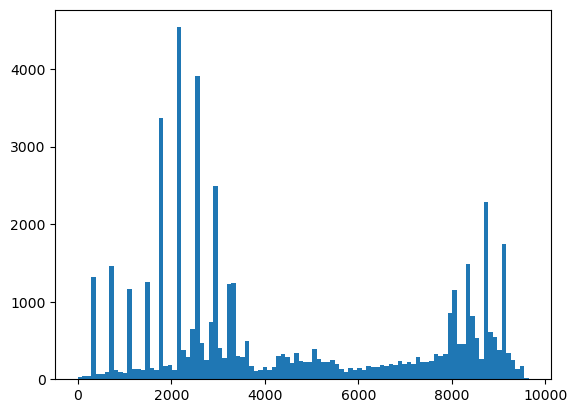

In [13]:
plt.hist(whi_ctos['CHD_DY'],bins=100)

In [14]:
73 * 30

2190

In [8]:
whi_cont

,Unnamed: 0,AGE,F20DAYS,LSTVISDY,LSTMAMDY,LSTPAPDY,TIMELAST,F2DAYS,F30DAYS,F31DAYS,...,HIP,SYST,DIAS,BMI,WHR,CBCDAYS,HEMATOCR,HEMOGLBN,PLATELET,WBC
0,0,68.0,-56.0,-275.289118,-762.0,-759.057793,7.245407,-66.0,-36.0,-36.0,...,92.000000,105.0,70.0,20.70313,0.760870,-56.0,36.9,12.0,235.0,4.6
1,1,55.0,-101.0,-139.000000,-353.0,-475.000000,1.249180,-147.0,-35.0,-45.0,...,92.000000,113.0,72.0,22.57050,0.798910,-101.0,36.5,12.2,192.0,3.4
2,2,54.0,-74.0,-201.000000,-141.0,-201.000000,4.174880,-229.0,-42.0,-42.0,...,120.000000,118.0,85.0,38.52147,0.879170,-74.0,38.8,13.4,264.0,6.6
3,3,54.0,-64.0,-92.000000,-1372.0,-759.057793,0.920450,-226.0,-34.0,-34.0,...,137.000000,124.0,74.0,36.79474,0.766420,-64.0,39.8,13.8,195.0,5.5
4,4,54.0,-69.0,-117.000000,-785.0,-117.000000,1.577910,-69.0,-69.0,-42.0,...,106.500000,125.0,76.0,28.41658,0.812210,-44.0,41.6,14.2,221.0,10.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50114,50114,54.0,-2.0,-353.000000,-353.0,-353.000000,11.538460,-121.0,-2.0,-2.0,...,93.000000,116.0,76.0,21.66404,0.688170,-2.0,40.0,14.0,165.0,3.1
50115,50115,55.0,-4.0,-275.289118,-2908.0,-759.057793,7.245407,-26.0,-4.0,-4.0,...,87.000000,118.0,83.0,23.60807,0.793100,-4.0,34.1,11.4,253.0,4.9
50116,50116,70.0,-2.0,-354.000000,-566.0,-536.000000,11.571330,-130.0,-2.0,-2.0,...,105.731832,175.0,102.0,22.08815,0.812979,-2.0,41.0,13.9,396.0,4.9
50117,50117,70.0,-12.0,-50.000000,-141.0,-141.000000,1.249180,-24.0,-12.0,-12.0,...,87.000000,134.0,66.0,23.87719,0.908050,-12.0,38.5,13.3,233.0,5.9


In [9]:
whi_ctos

,ID,OS,HRTARM,CHD_E,BREAST_E,STROKE_E,PE_E,ENDMTRL_E,COLORECTAL_E,BKHIP_E,...,STROKE_DY,PE_DY,ENDMTRL_DY,COLORECTAL_DY,BKHIP_DY,DEATH_DY,PTCA_DY,DVT_DY,GLBL_DY,HRTGRP
0,500001,0,1,0,0,0,0,0,0,0,...,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,NaN
1,500025,0,1,0,0,0,0,0,0,0,...,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,NaN
2,500042,0,1,0,0,0,0,0,0,0,...,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,NaN
3,500066,0,0,0,0,0,0,0,0,0,...,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,2921.0,NaN
4,500072,0,0,0,0,0,0,0,0,0,...,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,2555.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50114,699983,1,0,0,0,0,0,0,0,0,...,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,9067.0,0.0
50115,699986,1,0,0,0,0,0,0,0,0,...,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,2491.0,0.0
50116,699990,1,0,0,0,0,0,0,0,0,...,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,2451.0,0.0
50117,699992,1,1,0,0,0,0,0,0,0,...,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,3244.0,1.0


In [12]:
whi_merged

,ID,OS,HRTARM,CHD_E,BREAST_E,STROKE_E,PE_E,ENDMTRL_E,COLORECTAL_E,BKHIP_E,...,DIASTOL_<90,DIASTOL_>=90,BMIC_Extreme Obesity III (>= 40),BMIC_Normal (18.5 - 24.9),BMIC_Obesity I (30.0 - 34.9),BMIC_Obesity II (35.0 - 39.9),BMIC_Overweight (25.0 - 29.9),BMIC_Underweight (< 18.5),SAMEDRAW_No,SAMEDRAW_Yes
0,500001,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,500025,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
2,500042,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,500066,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,500072,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50114,699983,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
50115,699986,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
50116,699990,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
50117,699992,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


In [6]:
pd.read_csv('/data/whi/main_study_documentation/Data Dictionary.pdf')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 10: invalid continuation byte

In [5]:
whi

,Unnamed: 0,AGE,F20DAYS,LSTVISDY,LSTMAMDY,LSTPAPDY,TIMELAST,F2DAYS,F30DAYS,F31DAYS,...,HIP,SYST,DIAS,BMI,WHR,CBCDAYS,HEMATOCR,HEMOGLBN,PLATELET,WBC
0,0,68.0,-56.0,-275.289118,-762.0,-759.057793,7.245407,-66.0,-36.0,-36.0,...,92.000000,105.0,70.0,20.70313,0.760870,-56.0,36.9,12.0,235.0,4.6
1,1,55.0,-101.0,-139.000000,-353.0,-475.000000,1.249180,-147.0,-35.0,-45.0,...,92.000000,113.0,72.0,22.57050,0.798910,-101.0,36.5,12.2,192.0,3.4
2,2,54.0,-74.0,-201.000000,-141.0,-201.000000,4.174880,-229.0,-42.0,-42.0,...,120.000000,118.0,85.0,38.52147,0.879170,-74.0,38.8,13.4,264.0,6.6
3,3,54.0,-64.0,-92.000000,-1372.0,-759.057793,0.920450,-226.0,-34.0,-34.0,...,137.000000,124.0,74.0,36.79474,0.766420,-64.0,39.8,13.8,195.0,5.5
4,4,54.0,-69.0,-117.000000,-785.0,-117.000000,1.577910,-69.0,-69.0,-42.0,...,106.500000,125.0,76.0,28.41658,0.812210,-44.0,41.6,14.2,221.0,10.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50114,50114,54.0,-2.0,-353.000000,-353.0,-353.000000,11.538460,-121.0,-2.0,-2.0,...,93.000000,116.0,76.0,21.66404,0.688170,-2.0,40.0,14.0,165.0,3.1
50115,50115,55.0,-4.0,-275.289118,-2908.0,-759.057793,7.245407,-26.0,-4.0,-4.0,...,87.000000,118.0,83.0,23.60807,0.793100,-4.0,34.1,11.4,253.0,4.9
50116,50116,70.0,-2.0,-354.000000,-566.0,-536.000000,11.571330,-130.0,-2.0,-2.0,...,105.731832,175.0,102.0,22.08815,0.812979,-2.0,41.0,13.9,396.0,4.9
50117,50117,70.0,-12.0,-50.000000,-141.0,-141.000000,1.249180,-24.0,-12.0,-12.0,...,87.000000,134.0,66.0,23.87719,0.908050,-12.0,38.5,13.3,233.0,5.9


In [ ]:
ORIG_COL_NAMES = ["twin", "b.head", "preterm", "momage", "bw", "b.marr", "nnhealth", "birth.o", "momhisp", "sex"]
CONT_COLS = ["b.head", "preterm", "momage", "bw", "nnhealth", "birth.o"]
DISC_COLS = ["twin", "b.marr", "momhisp", "sex"]
COL_NAME_DICT = {f"X{i+1}": col  for i,col in enumerate(ORIG_COL_NAMES)}

ihdp_df = pd.read_csv('data/ihdp/ihdp.csv')[ORIG_COL_NAMES]

scaler = MinMaxScaler()
ihdp_df[CONT_COLS] = scaler.fit_transform(ihdp_df[CONT_COLS])
ihdp_df[DISC_COLS] = ihdp_df[DISC_COLS] - 0.5

sns.heatmap(ihdp_df.corr(), cmap='RdBu')

In [ ]:
mmr_keys = ["IPCW", "CDR"]
CD = 10
UC = 0
jD = read_json('ihdp/diffPOihdp-highdiff_GC.json', CD, UC, mmr_keys)
jD = read_json('ihdp/samePOihdp_GC.json', CD, UC, mmr_keys)


m = 1
os_size = int(jD['rct_size'] * m)

t1 = time()

df_combined, df_comb_drop, RCTData, OSData = generate_data(CD, os_size, jD)
Fb_Y, Gb_C = est_nuisance(df_combined, df_comb_drop, jD)

print('RCT size: {}, OS size: {}, time elapsed: {:.2f}'.format(jD['rct_size'], os_size, time() - t1))

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

crop_prop = True

mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test

# for kind, key in enumerate(mmr_keys):
#     if 'Drop' in key:
#         df_mmr = df_comb_drop.copy()
#     else:
#         df_mmr = df_combined.copy()

#     if jD['crop_prop'] and ('Drop' not in key):
#         df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
#                 (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95) &\
#                 (1e-4 < df_mmr['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

#     if jD['crop_prop'] and ('Drop' in key):
#         df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
#                 (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95)].copy().reset_index(drop=True)

#     signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
#     mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(df_mmr, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)

In [ ]:
df_combined['Gb(T|X,S,A)'].min()

In [ ]:
for xname in COL_NAME_DICT.keys():
    plot_wit_fn(df_combined, laplacian_kernel, xname, "S0_cdr_Miss_None_est_CATE", "S1_cdr_Miss_None_est_CATE", plot_marg=False, weight_marg=True)
    plot_wit_fn(df_combined, laplacian_kernel, xname, "S0_cdr_Miss_None_est_CATE", "S1_cdr_Miss_None_est_CATE", plot_marg=True, weight_marg=False)

In [ ]:
np.clip([0.4,0.7], a_max=1000, a_min=0.5)

In [ ]:
data = np.array(df_combined['X10'])
dens = sma.nonparametric.KDEUnivariate(data)
dens.fit()
x = np.linspace(0,1,100) #restrict range to (0,1)
y = dens.evaluate(data)

In [ ]:
dens.evaluate(data).shape

In [ ]:
mmr_stats

In [ ]:
def calc_wit_fn(df, kernel, x_name, x_arr, signal0, signal1, weight_marg=True):
    kxx = kernel(x_arr.reshape(-1,1), np.array(df[x_name]).reshape(-1,1))
    psi = np.array(df[signal1] - df[signal0])
    
    if weight_marg:
        data = np.array(df[x_name])
        dens = sma.nonparametric.KDEUnivariate(data)
        dens.fit()
        #pdb.set_trace()
        return (kxx @ psi) / (len(psi) * np.clip(dens.evaluate(x_arr), a_max=1000, a_min=0.5)) , kxx, psi
    else:
        return (kxx @ psi) / len(psi), kxx, psi

def plot_wit_fn(df, kernel, x_name, signal0, signal1, plot_marg=False, weight_marg=True):
    plt.figure()
    if COL_NAME_DICT[x_name] in DISC_COLS:
        x_arr = np.array([-0.5,0.5])
        wit_fn,_,_ = calc_wit_fn(df, kernel, x_name, x_arr, signal0, signal1, weight_marg)
        plt.scatter(x_arr + 0.5, wit_fn)
    else:
        x_arr = np.linspace(0,1,101)
        wit_fn,_,_ = calc_wit_fn(df, kernel, x_name, x_arr, signal0, signal1, weight_marg)
        plt.plot(x_arr, wit_fn)
        
    plt.xlabel(COL_NAME_DICT[x_name])
    plt.ylabel('Witness function')
    plt.show()
    
    if plot_marg:
        plt.figure()
        plt.hist(df[x_name])
        plt.xlabel(COL_NAME_DICT[x_name])

In [ ]:
mis_spec = 'Fb'
cov_vals = np.zeros(CD+1)

s, a = 0,1
x = np.zeros(CD + 1)
key
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}_true']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = ty #
st_arr = sty  

func = interp1d(t_arr, st_arr, kind='linear', fill_value='extrapolate')

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
tbs_Y = RCTData.get_oracle_surv_curve(t_arr, cov_vals, f'Y{a}')

plt.figure()
plt.plot(t_arr, tbs_Y, label=f'true Y{a}', ls ='-.', alpha= 0.4)
plt.plot(t_arr, st_arr, label='est', ls='-', alpha= 0.4)
plt.plot(xnew, ynew, label='func approx', ls='--', alpha= 0.4)
plt.legend()
plt.show()

# Trange = tc.copy()

# t1 = time()
# q_arr = eval_Qfunc_arr_(s, a, x, Trange, Fb_Y, mis_spec)
# print(f"Time: {time() - t1}")
# plt.figure()
# plt.plot(Trange, q_arr)
# plt.show()

In [ ]:
t_arr

In [ ]:
mis_spec = 'None'
cov_vals = np.array([0,0, 1, 0, 1, 1, 0, 1, 1, 1 ,1])
cov_vals = np.zeros(11)


s, a = 1,1
x = np.zeros(CD + 1)
key
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')

ynew = func(t_arr)   # use interpolation function returned by `interp1d`
tbs_C = OSData.get_oracle_surv_curve(t_arr, cov_vals, f'C{a}')

plt.figure()
plt.plot(t_arr, tbs_C, label=f'true C{a}', ls ='-.', alpha= 0.4)
plt.plot(t_arr, st_arr, label='est', ls='-', alpha= 0.4)
plt.plot(t_arr, ynew, label='func approx', ls='--', alpha= 0.4)
plt.legend()
plt.show()

# Trange = tc.copy()

# t1 = time()
# q_arr = eval_Qfunc_arr_(s, a, x, Trange, Fb_Y, mis_spec)
# print(f"Time: {time() - t1}")
# plt.figure()
# plt.plot(Trange, q_arr)
# plt.show()

In [ ]:
row = 2088

s = df_combined.loc[row, 'S']
a = df_combined.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_combined.loc[row, 'T']
Delta = df_combined.loc[row, 'Delta']

df_combined.loc[row]

In [ ]:
np.array([1,1]) @ 0

In [ ]:
row = 922

s = df_mmr.loc[row, 'S']
a = df_mmr.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_mmr.loc[row, 'T']
Delta = df_mmr.loc[row, 'Delta']

df_mmr.loc[row]

In [ ]:
mis_spec = 'None'

In [ ]:
eval_surv_(Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}'], T)

In [ ]:
eval_int_term_(s, a, x, T, Gb_C, Fb_Y, mis_spec)

In [ ]:
eval_Ystar_(s, a, x, Delta, T, Gb_C, Fb_Y, mis_spec)

In [ ]:
eval_Qfunc_(s, a, x, T, Fb_Y, mis_spec)

In [ ]:
eval_mu_(s, 1, x, Fb_Y, mis_spec)

In [ ]:
s, a = 0, 0
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

t1 = time()
func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
result, error = quad(func, 0, t_arr.max() + 10, limit=5)

print(f"Time: {time()-t1:.2f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
pv = np.load('results/ihdp/samePOihdp/CD-10/UC-1/pvals.npy')
#csv = pd.read_csv('results/complete-IC/samePO/CD-10/UC-0/res_summary.csv')

np.mean(pv[2], axis=1)

In [ ]:
for s in range(2):
    for a in range(2):
        print('-----\n-----')
        #df = df_combined.query(f"S == {s} & A == {a}").copy()  # all data
        df = df_mmr.query(f"S == {s} & A == {a}").copy()       # goes into MMR (after cropping etc.)

        Ystar_No_miss = f'S{s}_Ystar{a}_Miss_None_est_CATE'
        Ystar_Fb_miss = f'S{s}_Ystar{a}_Miss_Fb_est_CATE'
        Ystar_Gb_miss = f'S{s}_Ystar{a}_Miss_Gb_est_CATE'
        
        mu_No_miss = f'S{s}_muxsa{a}_Miss_None_est_CATE'
        mu_Fb_miss = f'S{s}_muxsa{a}_Miss_Fb_est_CATE'
        mu_Gb_miss = f'S{s}_muxsa{a}_Miss_Gb_est_CATE'

        print("E[Y|S={}, A={}]: {:.2f}".format(s ,a, df[f'Y{a}'].mean()))
        print("E[Ystar_No_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_No_miss].mean()))
        print("E[Ystar_Fb_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_Fb_miss].mean()))
        print("E[Ystar_Gb_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_Gb_miss].mean()))
        print("E[mu_No_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_No_miss].mean()))
        print("E[mu_Fb_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_Fb_miss].mean()))
        print("E[mu_Gb_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_Gb_miss].mean()))

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()